In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import random

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from keras import layers, models, regularizers, optimizers
from keras.models import Sequential, load_model
from keras.regularizers import l2
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing import image

In [7]:
print(
"TensorFlow version:", tf.__version__)
print("Num GPUs Available", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.9.3
Num GPUs Available 1


In [ ]:
train_df = pd.read_csv(r'data/raw/emnist-balanced-train.csv', header=None)
test_df = pd.read_csv(r'data/raw/emnist-balanced-test.csv', header=None)
# Add test dataset into train dataset
df = pd.concat([train_df, test_df], ignore_index=True)
print(df.head())
# Clear memory
del train_df
del test_df

   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   45    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   36    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2   43    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


In [9]:
#Reading the file
label_map = pd.read_csv(r'data/raw/emnist-balanced-mapping.txt',
                        delimiter = ' ',
                        index_col=0,
                        header=None)
label_map = label_map.iloc[:, 0]

#Initialising an empty dictionary
label_dictionary = {}

#Running a loop for ASCII equivalent to character conversion
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

In [10]:
print(df.shape)
df.describe()

(131600, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,131600.000000,131600.0,131600.0,131600.0,131600.0,131600.000000,131600.000000,131600.000000,131600.000000,131600.000000,...,131600.000000,131600.0,131600.0,131600.000000,131600.000000,131600.0,131600.0,131600.0,131600.0,131600.0
mean,23.000000,0.0,0.0,0.0,0.0,0.002036,0.012728,0.019354,0.016284,0.017447,...,0.000266,0.0,0.0,0.001854,0.000243,0.0,0.0,0.0,0.0,0.0
std,13.564712,0.0,0.0,0.0,0.0,0.295477,1.312534,1.586618,1.521459,1.692130,...,0.096481,0.0,0.0,0.672608,0.088211,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,11.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,23.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,35.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,46.000000,0.0,0.0,0.0,0.0,63.000000,213.000000,217.000000,217.000000,217.000000,...,35.000000,0.0,0.0,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


<h1>Data preprocessing</h1>

In [11]:
# Is there any missing values
df.dropna(inplace=True)
num_missing_values = df.isnull().sum().sum()

# Remove duplicates if any
df.drop_duplicates(inplace=True)
num_duplicates = df.duplicated().sum()

# Make sure the grayscale values to be between 0 and 255
df = np.clip(df, 0, 255)
num_values_outside_range = ((df < 0) | (df > 255)).sum().sum()

# Check if we have any null values or duplicated rows or values outside (0, 255) range.
print(f"Missing Values: {num_missing_values}")
print(f"Duplicates: {num_duplicates}")
print(f"Values outside the range of 0 and 255: {num_values_outside_range}")

Missing Values: 0
Duplicates: 0
Values outside the range of 0 and 255: 0


In [12]:
# We split our dataframe into feature matrix (X) and target vector (y)
X = df.loc[:, 1:]
y = df.loc[:, 0]

X.shape, y.shape

del df

In [13]:
#Data Scaling to bring the input values between 0 to 1
X = X.astype('float32') / 255

# Convert target variable to integer labels
y = y.astype(int)

In [14]:
# Sample entry number 322
sample_image = X.iloc[322]
sample_label = y.iloc[322]
sample_image.shape, sample_label

((784,), 42)

Label entry No. 322: h


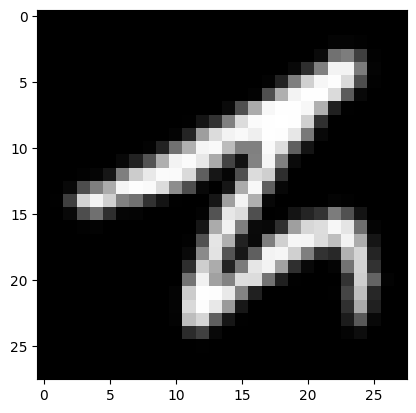

In [15]:
print("Label entry No. 322:", label_dictionary[sample_label])
plt.imshow(sample_image.values.reshape(28, 28), cmap=plt.cm.gray)
plt.show()

Label entry 42: h


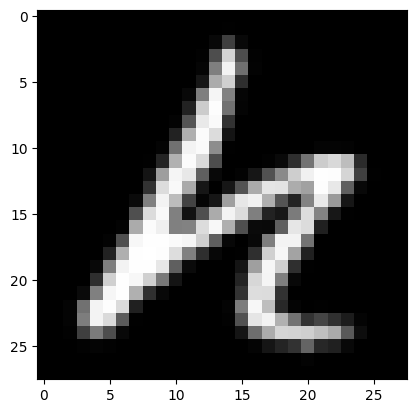

In [16]:
def flip_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(28, 28)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

print("Label entry 42:", label_dictionary[sample_label])
plt.imshow(flip_and_rotate(sample_image.values), cmap=plt.cm.gray)
plt.show()

In [17]:
# Next we want to apply reshape_and_rotate to all images in X_train
X = np.asarray(X)
X = np.apply_along_axis(flip_and_rotate, 1, X)
X.shape

(131598, 28, 28)

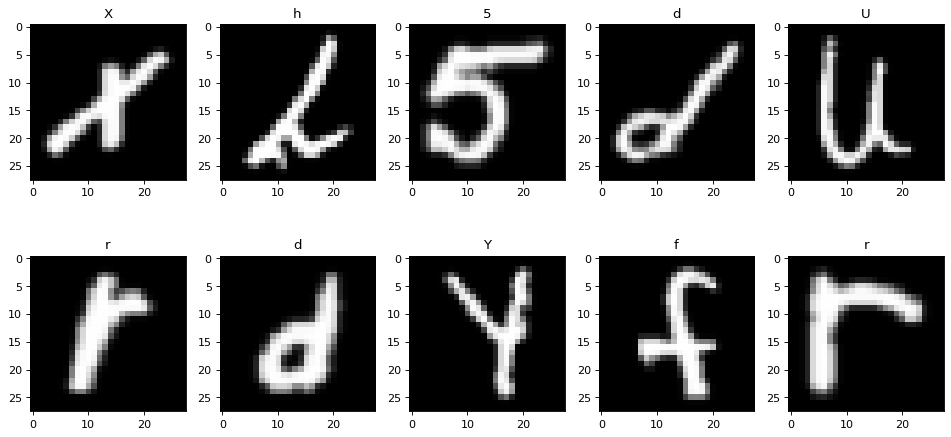

In [18]:
plt.figure(figsize=(12, 6), dpi=80)  # Adjust the figure size to accommodate two rows
for i in range(100, 110):  # Update the range to select 10 samples
    plt.subplot(2, 5, i - 99)  # Use 2 rows and 5 columns for displaying the samples
    plt.imshow(X[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y[i]])
plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [19]:
#Finding the number of output columns
number_of_classes = y.nunique()
number_of_classes

47

In [20]:
#One hot encoding of numpy array
y = np_utils.to_categorical(y, number_of_classes)
y.shape

(131598, 47)

In [21]:
# Reshaping the train data
# As tensorflow requires 4D Array, (batch X width X height X channel) and our x_train is 3D array (no. of images X width X height), we will be adding one more dimension to the x_train
X = X.reshape(-1, 28, 28, 1)
X.shape

(131598, 28, 28, 1)

<h2>Splitting data</h2>

In [22]:
# Split 20% validation 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                  y, 
                                                  test_size= 0.2,
                                                  stratify = y,
                                                  random_state=88)

del X
del y

<h2>Building CNN Model</h2>

In [41]:
cnn_model = Sequential()

# First Convolutional Block
cnn_model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
cnn_model.add(layers.Dropout(0.2))

# Second Convolutional Block
cnn_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
cnn_model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
cnn_model.add(layers.Dropout(0.3))

# Third Convolutional Block
cnn_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
cnn_model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
cnn_model.add(layers.Dropout(0.4))

# Flatten and Fully Connected Layers
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(layers.Dropout(0.4))
cnn_model.add(layers.Dense(number_of_classes, activation='softmax'))


# Compile the Model with a Lower Learning Rate
optimizer = optimizers.Adam(learning_rate=1e-3)
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 7, 7, 64)         

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)


datagen.fit(X_train)

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

mcp_save = ModelCheckpoint('./saved/cnn.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='auto')

RLP = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=0.0001)

In [ ]:
history = cnn_model.fit(datagen.flow(X_train,y_train,),
                        epochs=30,
                        batch_size=32,
                        verbose=1,
                        validation_data=(X_test, y_test),
                        callbacks=[mcp_save, early_stopping, RLP])

Epoch 1/30
3287/3290 [============================>.] - ETA: 0s - loss: 1.3048 - accuracy: 0.6065
Epoch 1: val_loss improved from inf to 0.45797, saving model to ./saved\cnn.h5
3290/3290 [==============================] - 29s 9ms/step - loss: 1.3044 - accuracy: 0.6066 - val_loss: 0.4580 - val_accuracy: 0.8439 - lr: 0.0010
Epoch 2/30
3286/3290 [============================>.] - ETA: 0s - loss: 0.7349 - accuracy: 0.7587
Epoch 2: val_loss improved from 0.45797 to 0.38449, saving model to ./saved\cnn.h5
3290/3290 [==============================] - 28s 9ms/step - loss: 0.7350 - accuracy: 0.7586 - val_loss: 0.3845 - val_accuracy: 0.8645 - lr: 0.0010
Epoch 3/30
3286/3290 [============================>.] - ETA: 0s - loss: 0.6563 - accuracy: 0.7832
Epoch 3: val_loss improved from 0.38449 to 0.37009, saving model to ./saved\cnn.h5
3290/3290 [==============================] - 31s 9ms/step - loss: 0.6562 - accuracy: 0.7832 - val_loss: 0.3701 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 4/30
3289/3290

In [7]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

NameError: name 'history' is not defined

accuracy curve

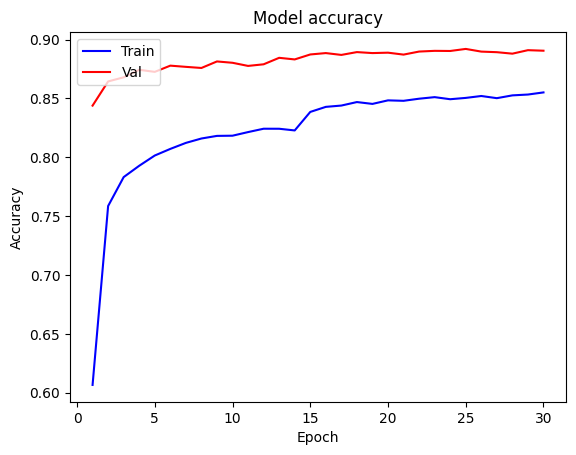

In [45]:
plotgraph(epochs, acc, val_acc)

loss curve

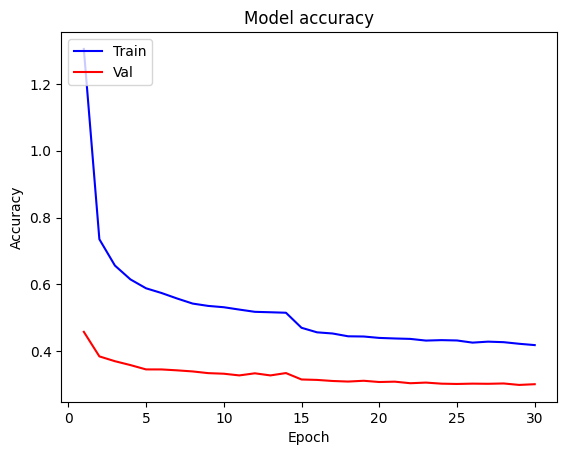

In [46]:
plotgraph(epochs, loss, val_loss)

In [6]:
# Load the saved model
cnn_model = load_model('./saved/cnn.h5')

In [48]:
# Evaluate new data
evaluation = cnn_model.evaluate(X_test, y_test)
print('Loss value is ',evaluation[0])
print('Accuracy value is ',evaluation[1])

823/823 [==============================] - 2s 2ms/step - loss: 0.2991 - accuracy: 0.8910
Loss value is  0.29913634061813354
Accuracy value is  0.891033411026001


823/823 [==============================] - 1s 1ms/step


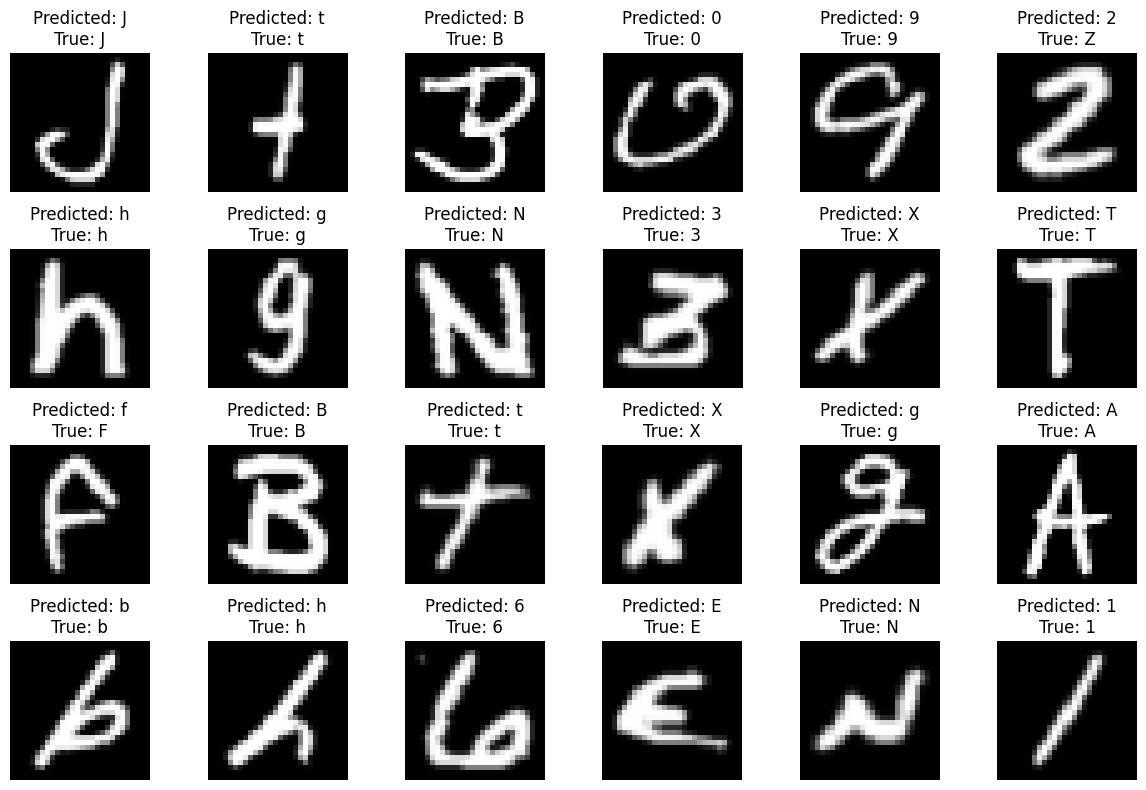

In [49]:
# Visualising some predicted values

#Prediction
y_pred = cnn_model.predict(X_test)

# Set the number of samples to display
num_samples = 24

# Get random indices for the samples
random_indices = random.sample(range(len(X_test)), num_samples)

# Create a figure with subplots
fig = plt.figure(figsize=(12, 8))

for i, idx in enumerate(random_indices):
    # Create a subplot for each sample
    ax = fig.add_subplot(4, 6, i+1)

    # Display the image
    ax.imshow(X_test[idx], cmap=plt.cm.gray)

    # Get the predicted and true labels
    predicted_label = label_dictionary[y_pred[idx].argmax()]
    true_label = label_dictionary[y_test[idx].argmax()]

    # Set the title with prediction and true label
    ax.set_title("Predicted: {}\nTrue: {}".format(predicted_label, true_label))

    # Remove the axis ticks and labels
    ax.axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()